l=1, torch=0.0007233619689941406, numpy=0.000823974609375, numpy_argmin=0.0004527568817138672, numpy_argmin_numba=2.3433027267456055
l=11, torch=0.0032608509063720703, numpy=0.006857872009277344, numpy_argmin=0.0020904541015625, numpy_argmin_numba=0.0031280517578125
l=21, torch=0.012638330459594727, numpy=0.01013493537902832, numpy_argmin=0.0024940967559814453, numpy_argmin_numba=0.00511932373046875
l=31, torch=0.010987043380737305, numpy=0.014781475067138672, numpy_argmin=0.0025568008422851562, numpy_argmin_numba=0.007213115692138672
l=41, torch=0.016646623611450195, numpy=0.01794576644897461, numpy_argmin=0.003098726272583008, numpy_argmin_numba=0.010040044784545898
l=51, torch=0.02284717559814453, numpy=0.025571107864379883, numpy_argmin=0.0032508373260498047, numpy_argmin_numba=0.010632038116455078
l=61, torch=0.023595094680786133, numpy=0.026241540908813477, numpy_argmin=0.0033545494079589844, numpy_argmin_numba=0.012357950210571289
l=71, torch=0.028439044952392578, numpy=0.033997

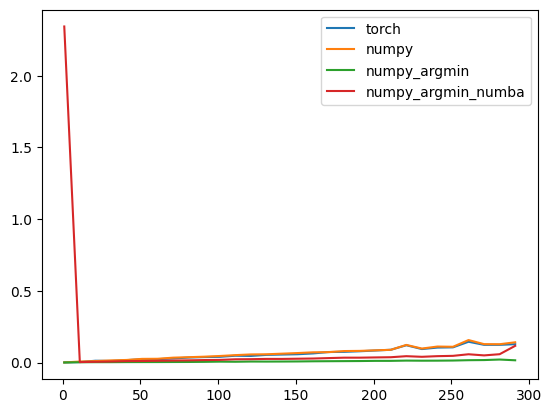

In [9]:
import torch as th
from numba import njit
import numpy as np
import time
import matplotlib.pyplot as plt


def find_length_torch(messages: th.Tensor) -> th.Tensor:
    max_k = messages.size(1)
    zero_mask = messages == 0

    lengths = max_k - (zero_mask.cumsum(dim=1) > 0).sum(dim=1)
    lengths.add_(1).clamp_(max=max_k)

    return lengths


def find_length_numpy(messages: np.ndarray) -> np.ndarray:
    max_k = messages.shape[1]
    zero_mask = messages == 0
    lengths = max_k - (np.cumsum(zero_mask, axis=1) > 0).sum(axis=1)
    lengths += 1
    lengths = np.clip(lengths, a_min=None, a_max=max_k)

    return lengths


def find_length_torch_argmin(messages: th.Tensor) -> th.Tensor:
    return th.argmin(messages, dim=1)


def find_length_numpy_argmin(messages: np.ndarray) -> np.ndarray:
    return np.argmin(messages, axis=1)


@njit
def find_length_numpy_argmin_numba(messages: np.ndarray) -> np.ndarray:
    return np.argmin(messages, axis=1)


lengths = list(range(1, 300, 10))
times_th = []
times_np = []
times_np_argmin = []
times_np_argmin_numba = []
for l in lengths:
    messages_th = th.randint(0, 5, (100000, l))
    messages_np = messages_th.numpy()

    start = time.time()
    find_length_torch(messages_th)
    elapsed = time.time() - start
    times_th.append(elapsed)

    start = time.time()
    find_length_numpy(messages_np)
    elapsed = time.time() - start
    times_np.append(elapsed)

    start = time.time()
    find_length_numpy_argmin(messages_np)
    elapsed = time.time() - start
    times_np_argmin.append(elapsed)

    start = time.time()
    find_length_numpy_argmin_numba(messages_np)
    elapsed = time.time() - start
    times_np_argmin_numba.append(elapsed)

    print(
        f"l={l}, torch={times_th[-1]}, numpy={times_np[-1]}, numpy_argmin={times_np_argmin[-1]}, numpy_argmin_numba={times_np_argmin_numba[-1]}"
    )


plt.plot(lengths, times_th, label="torch")
plt.plot(lengths, times_np, label="numpy")
plt.plot(lengths, times_np_argmin, label="numpy_argmin")
plt.plot(lengths, times_np_argmin_numba, label="numpy_argmin_numba")
plt.legend()
plt.show()

l=1, numpy=0.005671501159667969, numpy_numba=0.002223491668701172
l=11, numpy=0.011358499526977539, numpy_numba=0.014526605606079102
l=21, numpy=0.02280282974243164, numpy_numba=0.035494089126586914
l=31, numpy=0.0287020206451416, numpy_numba=0.10850286483764648
l=41, numpy=0.048584938049316406, numpy_numba=0.10336422920227051
l=51, numpy=0.060756683349609375, numpy_numba=0.1343400478363037
l=61, numpy=0.06420683860778809, numpy_numba=0.16223835945129395
l=71, numpy=0.06805682182312012, numpy_numba=0.19482755661010742
l=81, numpy=0.07511734962463379, numpy_numba=0.23894596099853516
l=91, numpy=0.08244180679321289, numpy_numba=0.2543754577636719
l=101, numpy=0.09041595458984375, numpy_numba=0.34700727462768555
l=111, numpy=0.11209797859191895, numpy_numba=0.4525935649871826
l=121, numpy=0.11072397232055664, numpy_numba=0.34238362312316895
l=131, numpy=0.11994361877441406, numpy_numba=0.3599386215209961
l=141, numpy=0.18334102630615234, numpy_numba=0.45847439765930176
l=151, numpy=0.1522

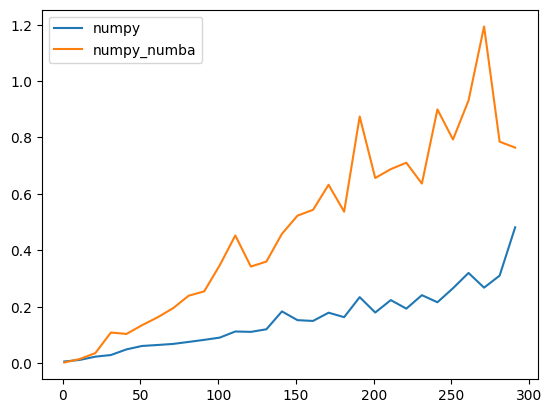

In [38]:
import torch as th
import editdistance
from numba import njit
import numpy as np
import time
import matplotlib.pyplot as plt


def find_length(messages: np.ndarray) -> np.ndarray:
    return np.argmin(messages, axis=1)


# バグあり！
def zero_replace(messages: th.Tensor):
    length = find_length(messages)
    max_len = messages.shape[1]
    mask_eos = (
        1
        - th.cumsum(
            th.nn.functional.one_hot(length.long(), num_classes=max_len + 1),
            dim=1,
        )[:, :-1]
    )
    return messages * mask_eos


def zero_replace_numpy(messages: np.ndarray) -> np.ndarray:
    lengths = find_length(messages)
    max_len = messages.shape[1]
    mask_eos = 1 - np.cumsum(np.eye(max_len + 1)[lengths.astype(int)], axis=1)[:, :-1]
    return (messages * mask_eos).astype(int)


@njit
def zero_replace_numpy_numba(messages: np.ndarray) -> np.ndarray:
    # lengths = find_length_numba(messages)
    lengths = np.argmin(messages, axis=1)
    max_len = messages.shape[1]
    mask_eos = np.eye(max_len + 1)[lengths]
    for i in range(1, max_len + 1):
        mask_eos[:, i] += mask_eos[:, i - 1]
    mask_eos = 1 - mask_eos[:, :-1]
    return messages * mask_eos


messages_th = th.randint(0, 5, (10, 10))
messages_np = messages_th.numpy()

replaced_np = zero_replace_numpy(messages_np)
replaced_np_numba = zero_replace_numpy_numba(messages_np)

lengths = list(range(1, 301, 10))
times_np = []
times_np_numba = []
for l in lengths:
    messages_np = np.random.randint(0, 5, (100000, l))

    start = time.time()
    zero_replace_numpy(messages_np)
    elapsed = time.time() - start
    times_np.append(elapsed)

    start = time.time()
    zero_replace_numpy_numba(messages_np)
    elapsed = time.time() - start
    times_np_numba.append(elapsed)

    print(f"l={l}, numpy={times_np[-1]}, numpy_numba={times_np_numba[-1]}")

plt.plot(lengths, times_np, label="numpy")
plt.plot(lengths, times_np_numba, label="numpy_numba")
plt.legend()
plt.show()

In [52]:
import torch as th
import editdistance
from numba import njit
import numpy as np
import time
import matplotlib.pyplot as plt


def find_length(messages: np.ndarray) -> np.ndarray:
    return np.argmin(messages, axis=1) + 1


def zero_replace(messages: np.ndarray, lengths: np.ndarray | None = None) -> np.ndarray:
    if lengths is None:
        lengths = find_length(messages)
    max_len = messages.shape[1]
    mask_eos = 1 - np.cumsum(np.eye(max_len + 1)[lengths.astype(int)], axis=1)[:, :-1]
    return (messages * mask_eos).astype(int)


@njit
def edit_distance(s1: np.ndarray, s2: np.ndarray):
    if len(s1) < len(s2):
        return edit_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = np.arange(len(s2) + 1, dtype=np.int64)
    for i, c1 in enumerate(s1):
        current_row = np.zeros(len(s2) + 1, dtype=np.int64)
        current_row[0] = i + 1
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row[j + 1] = min(insertions, deletions, substitutions)
        previous_row = current_row

    return previous_row[-1]


def lansim(
    message1: np.ndarray,
    message2: np.ndarray,
    length1: np.ndarray | None = None,
    length2: np.ndarray | None = None,
):
    if length1 is None:
        length1 = find_length(message1)
    if length2 is None:
        length2 = find_length(message2)

    tensor1_trimmed = [np.trim_zeros(seq, trim="b") for seq in message1]
    tensor2_trimmed = [np.trim_zeros(seq, trim="b") for seq in message2]

    edit_distances = [
        editdistance.eval(seq1, seq2)
        for seq1, seq2 in zip(tensor1_trimmed, tensor2_trimmed)
    ]

    return 1 - np.array(edit_distances) / np.maximum(length1, length2)


def lansim_fastedit(
    message1: np.ndarray,
    message2: np.ndarray,
    length1: np.ndarray | None = None,
    length2: np.ndarray | None = None,
):
    if length1 is None:
        length1 = find_length(message1)
    if length2 is None:
        length2 = find_length(message2)

    tensor1_trimmed = [np.trim_zeros(seq, trim="b") for seq in message1]
    tensor2_trimmed = [np.trim_zeros(seq, trim="b") for seq in message2]

    edit_distances = [
        edit_distance(seq1, seq2)
        for seq1, seq2 in zip(tensor1_trimmed, tensor2_trimmed)
    ]

    return 1 - np.array(edit_distances) / np.maximum(length1, length2)


@njit
def lansim_numba(
    message1: np.ndarray,
    message2: np.ndarray,
    length1: np.ndarray | None = None,
    length2: np.ndarray | None = None,
):
    if length1 is None:
        length1 = np.argmin(message1, axis=1) + 1
    if length2 is None:
        length1 = np.argmin(message2, axis=1) + 1

    tensor1_trimmed = [np.trim_zeros(seq, trim="b") for seq in message1]
    tensor2_trimmed = [np.trim_zeros(seq, trim="b") for seq in message2]

    edit_distances = [
        editdistance.eval(seq1, seq2)
        for seq1, seq2 in zip(tensor1_trimmed, tensor2_trimmed)
    ]

    return 1 - np.array(edit_distances) / np.maximum(length1, length2)


lengths = list(range(1, 50, 5))
times = []
times_fastedit = []
times_numba = []
for l in lengths:
    messages1 = np.random.randint(0, 5, (100000, l))
    messages2 = np.random.randint(0, 5, (100000, l))

    length1 = find_length(messages1)
    length2 = find_length(messages2)

    messages1 = zero_replace(messages1, length1)
    messages2 = zero_replace(messages2, length2)

    start = time.time()
    lan1 = lansim(messages1, messages2, length1, length2)
    elapsed = time.time() - start
    times.append(elapsed)

    start = time.time()
    lan2 = lansim_fastedit(messages1, messages2, length1, length2)
    elapsed = time.time() - start
    times_fastedit.append(elapsed)

    start = time.time()
    lan3 = lansim_numba(messages1, messages2, length1, length2)
    elapsed = time.time() - start
    times_numba.append(elapsed)

    print(l)

    assert np.allclose(lan1, lan2, lan3)

plt.plot(lengths, times, label="torch")
plt.plot(lengths, times_fastedit, label="torch_fastedit")
plt.plot(lengths, times_numba, label="torch_numba")
plt.legend()
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Use of unsupported NumPy function 'numpy.trim_zeros' or unsupported use of the function.

File "../../../../../tmp/ipykernel_2803/1978981205.py", line 99:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_2803/1978981205.py (99)

File "../../../../../tmp/ipykernel_2803/1978981205.py", line 99:
<source missing, REPL/exec in use?>
